In [53]:
import os
import zipfile
import pandas as pd
import numpy as np
import magic
import os 
import umap
from scipy.stats import spearmanr
import harmonypy as hm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
import matplotlib.pyplot as plt
import scanpy as sc

Installments
- magic

# Step 0: Download the training data

In [54]:
# get current path 
path_data = os.getcwd() 

### TRaining data information

In [55]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")

In [56]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [57]:
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")

In [58]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [59]:
sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")

In [60]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [61]:
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

In [62]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [63]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [64]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [93]:
sc_pancreas_metadata.Celltype.nunique()

13

### Test data information

In [65]:
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [66]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [67]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


Dropout in Single cell data: When a gene is observed at a moderate or high expression level in one cell but not detected in another cell. An expressed transcript is not detected. 
- reasons for dropout: biological, or non-biological. 
- biological: indicates information about cell states
- non-biological: technical zeros, which occur during the preparation of biological samples for sequencing, and sampling zeros, which arise due to limited sequencing depths

Good imputation methods for single cell data
- should achieve: 
1. accurate estimation of missing values
- should avoid: 
1. overfitting or oversmoothing: could lead to loss of biological information or variability 
2. loss of sparsity

Samples  processed by different technicians and/or at different time points could lead to batch effect
- how batch effect may affect single cell data: could lead to variation in sample groups that are caused by technical arrangements rather than biological factors, which could lead to false conclusions 
- methods to overcome potentially confounding effects: eliminate technical noise or bias so that observed variance in gene expression variance primarily reflects true biological variance.
- use some batch correction algorithms: ex: MNN, CCA, Harmony 


# Step 1: Perform the imputation

Methods to try for imputation 
- MAGIC
- ZINB VAE AND ZINB CVAE helps impute dropout effect

In [68]:
magic_operator = magic.MAGIC()
sc_pancreas_imputed = magic_operator.fit_transform(sc_pancreas)


Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.97 seconds.
    Calculating KNN search...
    Calculated KNN search in 94.94 seconds.
    Calculating affinities...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 95.52 seconds.
  Calculated graph and diffusion operator in 195.53 seconds.
  Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/graphtools/base.py:554: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.61 seconds.
Calculated MAGIC in 197.27 seconds.


- calculating the "bulkified" data means calculating the patient-wide average of gene expression (ex: avg SGIP1 exp for patient1, 2, 3, 4)
- To get the gene expression for patient j, you must simply average the library size-corrected values of the gene expression over all cells of the same patient.
- average spearman's correlation will be calculated for all patients in the test set 

In [69]:
def bulkification(sc_data):
    patient_ids = sorted(list(set([col.split('_')[0] for col in sc_data.columns])))
    bulkified = pd.DataFrame(columns=patient_ids, index=sc_data.index)
    for patient_id in patient_ids:
        # Select columns belonging to the same patient
        patient_columns = [col for col in sc_data.columns if col.startswith(patient_id)]
        patient_data = sc_data[patient_columns]
        
        # Calculate the mean expression for each gene for the current patient
        mean_expression = patient_data.mean(axis=1)
        bulkified[patient_id] = mean_expression
    return bulkified

In [70]:
bulkified_train = bulkification(sc_pancreas_imputed)
# TODO: NOTE I'M NOT SURE IF IT'S LOG2 OR LOG10
log_transformed_bulk_data = np.log2(bulk_pancreas + 1)

In [71]:
def calc_spearman(log_transformed_bulk_data, bulkified):
    patient_ids = sorted(list(set([col.split('_')[0] for col in bulkified.columns])))
    spearman_correlations = []
    for patient_id in patient_ids:
        spearman_correlation = spearmanr(log_transformed_bulk_data[patient_id], bulkified[patient_id])[0]
        spearman_correlations.append(spearman_correlation)
    return spearman_correlations

In [72]:
spearman_correlations = calc_spearman(log_transformed_bulk_data, bulkified_train)
print(spearman_correlations)

[0.9380227544395866, 0.9347507112021005, 0.9322098942877166, 0.9442370516977916]


# Step 2: Perform clustering 

- clustering output can be performed on raw/imputed counts
- free to do whatever transformations on data

Batch correction methods
- regression based methods (ComBat)
- dimensionality reduction methods (Harmony, Seurat, iNMF)
- deep learning based models (BERMUDA, scVI, scVAE)

--> trying out LIGER, Harmony, Seurat 

In [73]:
# number of clusters 
n_clusters = sc_pancreas_metadata.Celltype.nunique()
cluster_types = sc_pancreas_metadata.Celltype.unique()

In [84]:
# preprocessing: scale data, normalize, and reduce dimensionality
sc_pancreas_ad = sc.AnnData(sc_pancreas.T)
# seurat pipeline
sc_pancreas_ad_seurat = sc.pp.recipe_seurat(sc_pancreas_ad, copy=True)
sc_pancreas_ad_zheng = sc.pp.recipe_zheng17(sc_pancreas_ad, log=True, n_top_genes=5000, copy=True)

In [75]:
# do dimensionality reduction then feed into harmony to do batch correction 
sc_pancreas_ad_seurat_pcs = PCA(n_components=50).fit_transform(sc_pancreas_ad_seurat.X)
sc_pancreas_ad_zheng_pcs = PCA(n_components=50).fit_transform(sc_pancreas_ad_zheng.X)

In [76]:
# using harmony to do batch correction and clustering 
harmony_seurat = hm.run_harmony(data_mat = sc_pancreas_ad_seurat_pcs, meta_data= sc_pancreas_metadata,
                                vars_use = 'Sample')
harmony_zheng = hm.run_harmony(data_mat = sc_pancreas_ad_zheng_pcs, meta_data= sc_pancreas_metadata,
                                vars_use = 'Sample')


2023-04-25 17:29:32,162 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-25 17:29:32,588 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-25 17:29:32,601 - harmonypy - INFO - Iteration 1 of 10
2023-04-25 17:29:33,040 - harmonypy - INFO - Iteration 2 of 10
2023-04-25 17:29:33,254 - harmonypy - INFO - Iteration 3 of 10
2023-04-25 17:29:33,617 - harmonypy - INFO - Iteration 4 of 10
2023-04-25 17:29:33,979 - harmonypy - INFO - Iteration 5 of 10
2023-04-25 17:29:34,235 - harmonypy - INFO - Iteration 6 of 10
2023-04-25 17:29:34,331 - harmonypy - INFO - Iteration 7 of 10
2023-04-25 17:29:34,477 - harmonypy - INFO - Iteration 8 of 10
2023-04-25 17:29:34,610 - harmonypy - INFO - Iteration 9 of 10
2023-04-25 17:29:34,737 - harmonypy - INFO - Iteration 10 of 10
2023-04-25 17:29:34,885 - harmonypy - INFO - Converged after 10 iterations
2023-04-25 17:29:34,893 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-25 17:29:

In [77]:
harmony_seurat_pcs = harmony_seurat.Z_corr
harmony_zheng_pcs = harmony_zheng.Z_corr

In [101]:
sc_pancreas_ad_seurat.obsm["X_pca"] = harmony_seurat_pcs.T
sc_pancreas_ad_zheng.obsm["X_pca"] = harmony_zheng_pcs.T

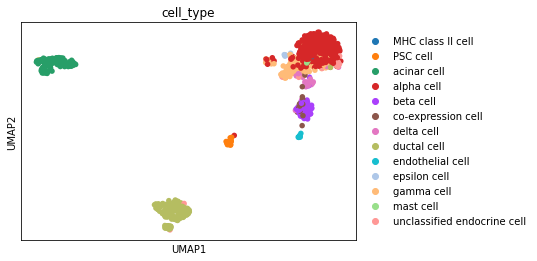

In [79]:
harmony_emb = np.array(sc_pancreas_ad_seurat.obsm["X_pca"])

# Run UMAP on the corrected embeddings
umap_mod = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=2)
umap_emb = umap_mod.fit_transform(harmony_emb)

# Add the UMAP coordinates to the AnnData object
sc_pancreas_ad_seurat.obsm["X_umap"] = umap_emb

sc_pancreas_ad_seurat.obs["cell_type"] = sc_pancreas_metadata.Celltype

# Plot the UMAP visualization
sc.pl.umap(sc_pancreas_ad_seurat, color=["cell_type"])


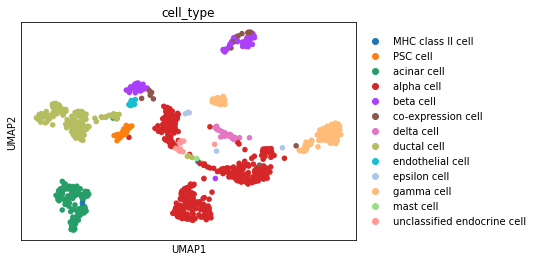

In [98]:
harmony_emb = np.array(sc_pancreas_ad_zheng.obsm["X_pca"])

# Run UMAP on the corrected embeddings
umap_mod = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=2)
umap_emb = umap_mod.fit_transform(harmony_emb)

# Add the UMAP coordinates to the AnnData object
sc_pancreas_ad_zheng.obsm["X_umap"] = umap_emb

sc_pancreas_ad_zheng.obs["cell_type"] = sc_pancreas_metadata.Celltype

# Plot the UMAP visualization
sc.pl.umap(sc_pancreas_ad_zheng, color=["cell_type"])

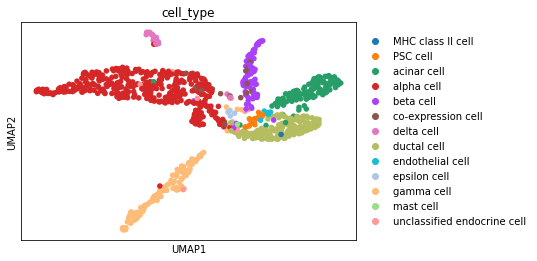

In [83]:
sc.pp.neighbors(sc_pancreas_ad, n_pcs=50)
sc.tl.umap(sc_pancreas_ad)
sc_pancreas_ad.obs["cell_type"] = sc_pancreas_metadata.Celltype
sc.pl.umap(sc_pancreas_ad, color= ["cell_type"])

         Falling back to preprocessing with `sc.pp.pca` and default params.


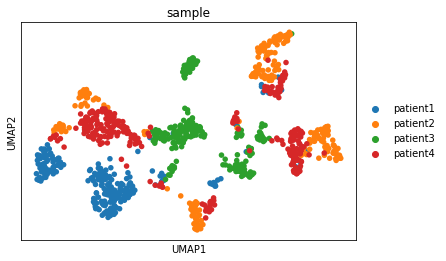

         Falling back to preprocessing with `sc.pp.pca` and default params.


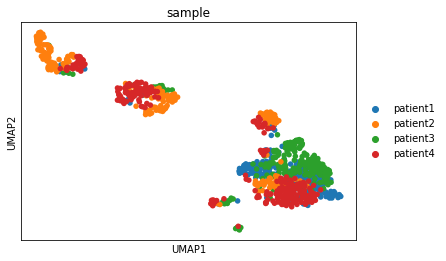

In [87]:
sc_pancreas_ad_wo_batch_zheng = sc.pp.recipe_seurat(sc_pancreas_ad, copy=True)
sc_pancreas_ad_wo_batch_seurat = sc.pp.recipe_zheng17(sc_pancreas_ad, log=True, n_top_genes=5000, copy=True)

sc.pp.neighbors(sc_pancreas_ad_wo_batch_seurat, n_pcs=50)
sc.tl.umap(sc_pancreas_ad_wo_batch_seurat)
sc_pancreas_ad_wo_batch_seurat.obs["cell_type"] = sc_pancreas_metadata.Celltype
sc_pancreas_ad_wo_batch_seurat.obs["sample"] = sc_pancreas_metadata.Sample
sc.pl.umap(sc_pancreas_ad_wo_batch_seurat, color= ["sample"])

sc.pp.neighbors(sc_pancreas_ad_wo_batch_zheng, n_pcs=50)
sc.tl.umap(sc_pancreas_ad_wo_batch_zheng)
sc_pancreas_ad_wo_batch_zheng.obs["cell_type"] = sc_pancreas_metadata.Celltype
sc_pancreas_ad_wo_batch_zheng.obs["sample"] = sc_pancreas_metadata.Sample
sc.pl.umap(sc_pancreas_ad_wo_batch_zheng, color= ["sample"])

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [102]:
# clustering with leiden 
sc.pp.neighbors(sc_pancreas_ad_zheng)
sc.tl.umap(sc_pancreas_ad_zheng)

sc.tl.leiden(sc_pancreas_ad_zheng)

sc.tl.leiden(sc_pancreas_ad_zheng, key_added= 'leiden_res0_25', resolution=0.25)
sc.tl.leiden(sc_pancreas_ad_zheng, key_added= 'leiden_res0_5', resolution=0.5)
sc.tl.leiden(sc_pancreas_ad_zheng, key_added = 'leiden_res0_6', resolution=0.6)
sc.tl.leiden(sc_pancreas_ad_zheng, key_added = 'leiden_res0_75', resolution=0.75)
sc.tl.leiden(sc_pancreas_ad_zheng, key_added= 'leiden_res1', resolution=1.0)


In [ ]:
sc.tl.leiden(sc_pancreas_ad_wo_batch_seurat)

# using different types of resolution 
# sc.tl.leiden(sc_pancreas_ad_seurat, key_added= 'leiden_res0_25', resolution=0.25)
# sc.tl.leiden(sc_pancreas_ad_seurat, key_added= 'leiden_res0_5', resolution=0.5)
# sc.tl.leiden(sc_pancreas_ad_seurat, key_added= 'leiden_res1', resolution=1.0)

In [ ]:
sc_pancreas_imputed_transformed = harmony_output.Z_corr

# clustering 
# agg_clustering = AgglomerativeClustering(n_clusters, affinity = harmony_output.dist_mat)
# # visualizing the clustering
# agg_clustering.fit(sc_pancreas_imputed_transformed.T)
# # getting the labels
# agg_labels = agg_clustering.labels_

# kmeans clustering
kmeans_clustering = KMeans(n_clusters)
kmeans_clustering.fit(sc_pancreas_imputed_transformed.T)
kmeans_labels = kmeans_clustering.labels_


# # getting the silhouette score
# ssc = silhouette_score(sc_pancreas_imputed_transformed.T, agg_labels)

# # getting the adjusted rand score
# ars = adjusted_rand_score(sc_pancreas_metadata.Celltype, agg_labels)

# # getting the v measure score
# v_score = v_measure_score(sc_pancreas_metadata.Celltype, agg_labels)



In [97]:
# create a umap with the metadata Celltype as the labels
umap_mod = umap.UMAP(n_components=2, random_state=42)
umap_mod.fit_transform(sc_pancreas)
# plot the umap
plt.figure(figsize=(10,10))
plt.scatter(umap_mod.embedding_[:, 0], umap_mod.embedding_[:, 1], c=sc_pancreas_metadata.Celltype, cmap='Spectral', s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the pancreas dataset', fontsize=24)
plt.show()


AttributeError: module 'umap' has no attribute 'UMAP'

# Step 3: Predict on the test data

Performing imputation to create imputed_bulkified.csv

In [36]:
sc_pancreas_imputed_test = magic_operator.transform(sc_pancreas_test)                        
bulkified = bulkification(sc_pancreas_imputed_test)
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
bulkified.columns = ["patient5","patient6","patient7"]
bulkified.index = sc_pancreas_test.index

Calculating imputation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.15 seconds.


### Perform clustering to assign cell cluster membership 

### Perform PCA to coordinates of the cells in the test dataset in the 50 first PCs computed on your data

# Step 4: Save the required files

In [ ]:
results_path = os.getcwd()
archive_name = "Jung_HuiJeong_Project2.zip" # TODO

In [ ]:
assert all(bulkified.columns == ["index","patient5","patient6","patient7"])

In [ ]:
assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
assert all(cluster_labels.columns == ["index","cluster"])

In [ ]:
assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])

In [ ]:
assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [ ]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
        [
            i in archive.namelist()
            for i in [
                "imputed_bulkified.csv",
                "cluster_membership.csv",
                "PCA.csv",
            ]
        ]
    )